In [27]:
import pandas as pd
train_df = pd.read_csv('./Text/train_set.csv', sep='\t', nrows=100)

In [28]:
train_df.head()

,label,text
0,2,2967 6758 339 2021 1854 3731 4109 3792 4149 15...
1,11,4464 486 6352 5619 2465 4802 1452 3137 5778 54...
2,3,7346 4068 5074 3747 5681 6093 1777 2226 7354 6...
3,2,7159 948 4866 2109 5520 2490 211 3956 5520 549...
4,3,3646 3055 3055 2490 4659 6065 3370 5814 2465 5...


In [29]:
%pylab inline
train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split(' ')))
print(train_df['text_len'].describe())

Populating the interactive namespace from numpy and matplotlib
count     100.000000
mean      872.320000
std       923.138191
min        64.000000
25%       359.500000
50%       598.000000
75%      1058.000000
max      7125.000000
Name: text_len, dtype: float64


Text(0.5, 1.0, 'Histogram of char count')

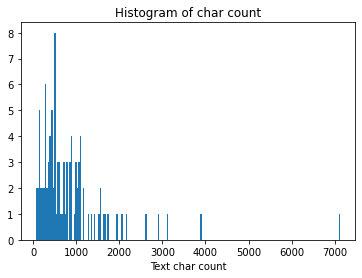

In [30]:
_ = plt.hist(train_df['text_len'], bins=200)
plt.xlabel('Text char count')
plt.title("Histogram of char count")

Text(0.5, 0, 'category')

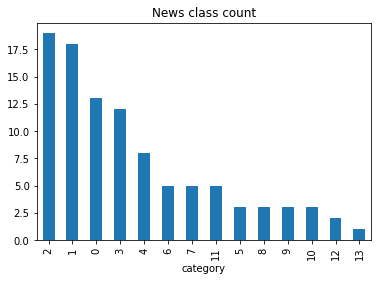

In [31]:
train_df['label'].value_counts().plot(kind='bar')
plt.title('News class count')
plt.xlabel("category")

In [32]:
from collections import Counter
all_lines = ' '.join(list(train_df['text']))
word_count = Counter(all_lines.split(" "))
word_count = sorted(word_count.items(), key=lambda d:d[1], reverse = True)

print("len(word_count)",len(word_count))

print("word_count[0]",word_count[0])

print("word_count[-1]",word_count[-1])

len(word_count) 2405
word_count[0] ('3750', 3702)
word_count[-1] ('5034', 1)


In [34]:
train_df['text_unique'] = train_df['text'].apply(lambda x: ' '.join(list(set(x.split(' ')))))
all_lines = ' '.join(list(train_df['text_unique']))
word_count = Counter(all_lines.split(" "))
word_count = sorted(word_count.items(), key=lambda d: int(d[1]), reverse = True)

print("word_count[0]: ", word_count[0]) 
print("word_count[1]: ", word_count[1])
print("word_count[2]: ", word_count[2]) 

word_count[0]:  ('3750', 99)
word_count[1]:  ('900', 99)
word_count[2]:  ('648', 96)


In [34]:
import logging
import random

import numpy as np
import torch

logging.basicConfig(level=logging.INFO, format='%(asctime)-15s %(levelname)s: %(message)s')

# set seed 
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)

# set cuda
gpu = 0
use_cuda = gpu >= 0 and torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(gpu)
    device = torch.device("cuda", gpu)
else:
    device = torch.device("cpu")
logging.info("Use cuda: %s, gpu id: %d.", use_cuda, gpu)

2021-05-25 16:51:49,350 INFO: Use cuda: False, gpu id: 0.


In [2]:
# split data to 10 fold
fold_num = 10
data_file = './Text/train_set.csv'
import pandas as pd


def all_data2fold(fold_num, num=10000):
    fold_data = []
    f = pd.read_csv(data_file, sep='\t', encoding='UTF-8')
    texts = f['text'].tolist()[:num]
    labels = f['label'].tolist()[:num]

    total = len(labels)

    index = list(range(total))
    np.random.shuffle(index)

    all_texts = []
    all_labels = []
    for i in index:
        all_texts.append(texts[i])
        all_labels.append(labels[i])

    label2id = {}
    for i in range(total):
        label = str(all_labels[i])
        if label not in label2id:
            label2id[label] = [i]
        else:
            label2id[label].append(i)

    all_index = [[] for _ in range(fold_num)]
    for label, data in label2id.items():
        # print(label, len(data))
        batch_size = int(len(data) / fold_num)
        other = len(data) - batch_size * fold_num
        for i in range(fold_num):
            cur_batch_size = batch_size + 1 if i < other else batch_size
            # print(cur_batch_size)
            batch_data = [data[i * batch_size + b] for b in range(cur_batch_size)]
            all_index[i].extend(batch_data)

    batch_size = int(total / fold_num)
    other_texts = []
    other_labels = []
    other_num = 0
    start = 0
    for fold in range(fold_num):
        num = len(all_index[fold])
        texts = [all_texts[i] for i in all_index[fold]]
        labels = [all_labels[i] for i in all_index[fold]]

        if num > batch_size:
            fold_texts = texts[:batch_size]
            other_texts.extend(texts[batch_size:])
            fold_labels = labels[:batch_size]
            other_labels.extend(labels[batch_size:])
            other_num += num - batch_size
        elif num < batch_size:
            end = start + batch_size - num
            fold_texts = texts + other_texts[start: end]
            fold_labels = labels + other_labels[start: end]
            start = end
        else:
            fold_texts = texts
            fold_labels = labels

        assert batch_size == len(fold_labels)

        # shuffle
        index = list(range(batch_size))
        np.random.shuffle(index)

        shuffle_fold_texts = []
        shuffle_fold_labels = []
        for i in index:
            shuffle_fold_texts.append(fold_texts[i])
            shuffle_fold_labels.append(fold_labels[i])

        data = {'label': shuffle_fold_labels, 'text': shuffle_fold_texts}
        fold_data.append(data)

    logging.info("Fold lens %s", str([len(data['label']) for data in fold_data]))

    return fold_data


fold_data = all_data2fold(10)

2021-05-25 12:16:46,022 INFO: Fold lens [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [3]:
# build train, dev, test data
fold_id = 9

# dev
dev_data = fold_data[fold_id]

# train
train_texts = []
train_labels = []
for i in range(0, fold_id):
    data = fold_data[i]
    train_texts.extend(data['text'])
    train_labels.extend(data['label'])

train_data = {'label': train_labels, 'text': train_texts}

# test
test_data_file = './Text/test_a.csv'
f = pd.read_csv(test_data_file, sep='\t', encoding='UTF-8')
texts = f['text'].tolist()
test_data = {'label': [0] * len(texts), 'text': texts}

In [4]:
# build vocab
from collections import Counter
from transformers import BasicTokenizer

basic_tokenizer = BasicTokenizer()


class Vocab():
    def __init__(self, train_data):
        self.min_count = 5
        self.pad = 0
        self.unk = 1
        self._id2word = ['[PAD]', '[UNK]']
        self._id2extword = ['[PAD]', '[UNK]']

        self._id2label = []
        self.target_names = []

        self.build_vocab(train_data)

        reverse = lambda x: dict(zip(x, range(len(x))))
        self._word2id = reverse(self._id2word)
        self._label2id = reverse(self._id2label)

        logging.info("Build vocab: words %d, labels %d." % (self.word_size, self.label_size))

    def build_vocab(self, data):
        self.word_counter = Counter()

        for text in data['text']:
            words = text.split()
            for word in words:
                self.word_counter[word] += 1

        for word, count in self.word_counter.most_common():
            if count >= self.min_count:
                self._id2word.append(word)

        label2name = {0: '科技', 1: '股票', 2: '体育', 3: '娱乐', 4: '时政', 5: '社会', 6: '教育', 7: '财经',
                      8: '家居', 9: '游戏', 10: '房产', 11: '时尚', 12: '彩票', 13: '星座'}

        self.label_counter = Counter(data['label'])

        for label in range(len(self.label_counter)):
            count = self.label_counter[label]
            self._id2label.append(label)
            self.target_names.append(label2name[label])

    def load_pretrained_embs(self, embfile):
        with open(embfile, encoding='utf-8') as f:
            lines = f.readlines()
            items = lines[0].split()
            word_count, embedding_dim = int(items[0]), int(items[1])

        index = len(self._id2extword)
        embeddings = np.zeros((word_count + index, embedding_dim))
        for line in lines[1:]:
            values = line.split()
            self._id2extword.append(values[0])
            vector = np.array(values[1:], dtype='float64')
            embeddings[self.unk] += vector
            embeddings[index] = vector
            index += 1

        embeddings[self.unk] = embeddings[self.unk] / word_count
        embeddings = embeddings / np.std(embeddings)

        reverse = lambda x: dict(zip(x, range(len(x))))
        self._extword2id = reverse(self._id2extword)

        assert len(set(self._id2extword)) == len(self._id2extword)

        return embeddings

    def word2id(self, xs):
        if isinstance(xs, list):
            return [self._word2id.get(x, self.unk) for x in xs]
        return self._word2id.get(xs, self.unk)

    def extword2id(self, xs):
        if isinstance(xs, list):
            return [self._extword2id.get(x, self.unk) for x in xs]
        return self._extword2id.get(xs, self.unk)

    def label2id(self, xs):
        if isinstance(xs, list):
            return [self._label2id.get(x, self.unk) for x in xs]
        return self._label2id.get(xs, self.unk)

    @property
    def word_size(self):
        return len(self._id2word)

    @property
    def extword_size(self):
        return len(self._id2extword)

    @property
    def label_size(self):
        return len(self._id2label)


vocab = Vocab(train_data)

2021-05-25 12:16:56,880 INFO: Build vocab: words 4337, labels 14.


In [5]:
# build module
import torch.nn as nn
import torch.nn.functional as F


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.weight.data.normal_(mean=0.0, std=0.05)

        self.bias = nn.Parameter(torch.Tensor(hidden_size))
        b = np.zeros(hidden_size, dtype=np.float32)
        self.bias.data.copy_(torch.from_numpy(b))

        self.query = nn.Parameter(torch.Tensor(hidden_size))
        self.query.data.normal_(mean=0.0, std=0.05)

    def forward(self, batch_hidden, batch_masks):
        # batch_hidden: b x len x hidden_size (2 * hidden_size of lstm)
        # batch_masks:  b x len

        # linear
        key = torch.matmul(batch_hidden, self.weight) + self.bias  # b x len x hidden

        # compute attention
        outputs = torch.matmul(key, self.query)  # b x len

        masked_outputs = outputs.masked_fill((1 - batch_masks).bool(), float(-1e32))

        attn_scores = F.softmax(masked_outputs, dim=1)  # b x len

        # 对于全零向量，-1e32的结果为 1/len, -inf为nan, 额外补0
        masked_attn_scores = attn_scores.masked_fill((1 - batch_masks).bool(), 0.0)

        # sum weighted sources
        batch_outputs = torch.bmm(masked_attn_scores.unsqueeze(1), key).squeeze(1)  # b x hidden

        return batch_outputs, attn_scores


# build word encoder
word2vec_path = './Text/word2vec.txt'
dropout = 0.15


class WordCNNEncoder(nn.Module):
    def __init__(self, vocab):
        super(WordCNNEncoder, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.word_dims = 100
        self.word_embed = nn.Embedding(vocab.word_size, self.word_dims, padding_idx=0)
        
        extword_embed = vocab.load_pretrained_embs(word2vec_path)
        extword_size, word_dims = extword_embed.shape
        logging.info("Load extword embed: words %d, dims %d." % (extword_size, word_dims))

        self.extword_embed = nn.Embedding(extword_size, word_dims, padding_idx=0)
        self.extword_embed.weight.data.copy_(torch.from_numpy(extword_embed))
        self.extword_embed.weight.requires_grad = False

        input_size = self.word_dims

        self.filter_sizes = [2, 3, 4]  # n-gram window
        self.out_channel = 100
        self.convs = nn.ModuleList([nn.Conv2d(1, self.out_channel, (filter_size, input_size), bias=True)
                                    for filter_size in self.filter_sizes])

    def forward(self, word_ids, extword_ids):
        # word_ids: sen_num x sent_len
        # extword_ids: sen_num x sent_len
        # batch_masks: sen_num x sent_len
        sen_num, sent_len = word_ids.shape

        word_embed = self.word_embed(word_ids)  # sen_num x sent_len x 100
        extword_embed = self.extword_embed(extword_ids)
        batch_embed = word_embed + extword_embed

        if self.training:
            batch_embed = self.dropout(batch_embed)

        batch_embed.unsqueeze_(1)  # sen_num x 1 x sent_len x 100

        pooled_outputs = []
        for i in range(len(self.filter_sizes)):
            filter_height = sent_len - self.filter_sizes[i] + 1
            conv = self.convs[i](batch_embed)
            hidden = F.relu(conv)  # sen_num x out_channel x filter_height x 1

            mp = nn.MaxPool2d((filter_height, 1))  # (filter_height, filter_width)
            pooled = mp(hidden).reshape(sen_num,
                                        self.out_channel)  # sen_num x out_channel x 1 x 1 -> sen_num x out_channel

            pooled_outputs.append(pooled)

        reps = torch.cat(pooled_outputs, dim=1)  # sen_num x total_out_channel

        if self.training:
            reps = self.dropout(reps)

        return reps


# build sent encoder
sent_hidden_size = 256
sent_num_layers = 2


class SentEncoder(nn.Module):
    def __init__(self, sent_rep_size):
        super(SentEncoder, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.sent_lstm = nn.LSTM(
            input_size=sent_rep_size,
            hidden_size=sent_hidden_size,
            num_layers=sent_num_layers,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, sent_reps, sent_masks):
        # sent_reps:  b x doc_len x sent_rep_size
        # sent_masks: b x doc_len

        sent_hiddens, _ = self.sent_lstm(sent_reps)  # b x doc_len x hidden*2
        sent_hiddens = sent_hiddens * sent_masks.unsqueeze(2)

        if self.training:
            sent_hiddens = self.dropout(sent_hiddens)

        return sent_hiddens

In [6]:
# build model
class Model(nn.Module):
    def __init__(self, vocab):
        super(Model, self).__init__()
        self.sent_rep_size = 300
        self.doc_rep_size = sent_hidden_size * 2
        self.all_parameters = {}
        parameters = []
        self.word_encoder = WordCNNEncoder(vocab)
        parameters.extend(list(filter(lambda p: p.requires_grad, self.word_encoder.parameters())))
        self.sent_encoder = SentEncoder(self.sent_rep_size)
        self.sent_attention = Attention(self.doc_rep_size)
        parameters.extend(list(filter(lambda p: p.requires_grad, self.sent_encoder.parameters())))
        parameters.extend(list(filter(lambda p: p.requires_grad, self.sent_attention.parameters())))

        self.out = nn.Linear(self.doc_rep_size, vocab.label_size, bias=True)
        parameters.extend(list(filter(lambda p: p.requires_grad, self.out.parameters())))

        if use_cuda:
            self.to(device)

        if len(parameters) > 0:
            self.all_parameters["basic_parameters"] = parameters

        logging.info('Build model with cnn word encoder, lstm sent encoder.')

        para_num = sum([np.prod(list(p.size())) for p in self.parameters()])
        logging.info('Model param num: %.2f M.' % (para_num / 1e6))

    def forward(self, batch_inputs):
        # batch_inputs(batch_inputs1, batch_inputs2): b x doc_len x sent_len
        # batch_masks : b x doc_len x sent_len
        batch_inputs1, batch_inputs2, batch_masks = batch_inputs
        batch_size, max_doc_len, max_sent_len = batch_inputs1.shape[0], batch_inputs1.shape[1], batch_inputs1.shape[2]
        batch_inputs1 = batch_inputs1.view(batch_size * max_doc_len, max_sent_len)  # sen_num x sent_len
        batch_inputs2 = batch_inputs2.view(batch_size * max_doc_len, max_sent_len)  # sen_num x sent_len
        batch_masks = batch_masks.view(batch_size * max_doc_len, max_sent_len)  # sen_num x sent_len

        sent_reps = self.word_encoder(batch_inputs1, batch_inputs2)  # sen_num x sent_rep_size

        sent_reps = sent_reps.view(batch_size, max_doc_len, self.sent_rep_size)  # b x doc_len x sent_rep_size
        batch_masks = batch_masks.view(batch_size, max_doc_len, max_sent_len)  # b x doc_len x max_sent_len
        sent_masks = batch_masks.bool().any(2).float()  # b x doc_len

        sent_hiddens = self.sent_encoder(sent_reps, sent_masks)  # b x doc_len x doc_rep_size
        doc_reps, atten_scores = self.sent_attention(sent_hiddens, sent_masks)  # b x doc_rep_size

        batch_outputs = self.out(doc_reps)  # b x num_labels

        return batch_outputs


model = Model(vocab)

2021-05-25 12:17:04,039 INFO: Load extword embed: words 5978, dims 100.
2021-05-25 12:17:04,065 INFO: Build model with cnn word encoder, lstm sent encoder.
2021-05-25 12:17:04,067 INFO: Model param num: 4.11 M.


In [7]:
# build optimizer
learning_rate = 2e-4
decay = .75
decay_step = 1000


class Optimizer:
    def __init__(self, model_parameters):
        self.all_params = []
        self.optims = []
        self.schedulers = []

        for name, parameters in model_parameters.items():
            if name.startswith("basic"):
                optim = torch.optim.Adam(parameters, lr=learning_rate)
                self.optims.append(optim)

                l = lambda step: decay ** (step // decay_step)
                scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=l)
                self.schedulers.append(scheduler)
                self.all_params.extend(parameters)

            else:
                Exception("no nameed parameters.")

        self.num = len(self.optims)

    def step(self):
        for optim, scheduler in zip(self.optims, self.schedulers):
            optim.step()
            scheduler.step()
            optim.zero_grad()

    def zero_grad(self):
        for optim in self.optims:
            optim.zero_grad()

    def get_lr(self):
        lrs = tuple(map(lambda x: x.get_lr()[-1], self.schedulers))
        lr = ' %.5f' * self.num
        res = lr % lrs
        return res

In [8]:
# build dataset
def sentence_split(text, vocab, max_sent_len=256, max_segment=16):
    words = text.strip().split()
    document_len = len(words)

    index = list(range(0, document_len, max_sent_len))
    index.append(document_len)

    segments = []
    for i in range(len(index) - 1):
        segment = words[index[i]: index[i + 1]]
        assert len(segment) > 0
        segment = [word if word in vocab._id2word else '<UNK>' for word in segment]
        segments.append([len(segment), segment])

    assert len(segments) > 0
    if len(segments) > max_segment:
        segment_ = int(max_segment / 2)
        return segments[:segment_] + segments[-segment_:]
    else:
        return segments


def get_examples(data, vocab, max_sent_len=256, max_segment=8):
    label2id = vocab.label2id
    examples = []

    for text, label in zip(data['text'], data['label']):
        # label
        id = label2id(label)

        # words
        sents_words = sentence_split(text, vocab, max_sent_len, max_segment)
        doc = []
        for sent_len, sent_words in sents_words:
            word_ids = vocab.word2id(sent_words)
            extword_ids = vocab.extword2id(sent_words)
            doc.append([sent_len, word_ids, extword_ids])
        examples.append([id, len(doc), doc])

    logging.info('Total %d docs.' % len(examples))
    return examples

In [9]:
# build loader

def batch_slice(data, batch_size):
    batch_num = int(np.ceil(len(data) / float(batch_size)))
    for i in range(batch_num):
        cur_batch_size = batch_size if i < batch_num - 1 else len(data) - batch_size * i
        docs = [data[i * batch_size + b] for b in range(cur_batch_size)]

        yield docs


def data_iter(data, batch_size, shuffle=True, noise=1.0):
    """
    randomly permute data, then sort by source length, and partition into batches
    ensure that the length of  sentences in each batch
    """

    batched_data = []
    if shuffle:
        np.random.shuffle(data)

        lengths = [example[1] for example in data]
        noisy_lengths = [- (l + np.random.uniform(- noise, noise)) for l in lengths]
        sorted_indices = np.argsort(noisy_lengths).tolist()
        sorted_data = [data[i] for i in sorted_indices]
    else:
        sorted_data = data
        
    batched_data.extend(list(batch_slice(sorted_data, batch_size)))

    if shuffle:
        np.random.shuffle(batched_data)

    for batch in batched_data:
        yield batch

In [10]:
# some function
from sklearn.metrics import f1_score, precision_score, recall_score


def get_score(y_ture, y_pred):
    y_ture = np.array(y_ture)
    y_pred = np.array(y_pred)
    f1 = f1_score(y_ture, y_pred, average='macro') * 100
    p = precision_score(y_ture, y_pred, average='macro') * 100
    r = recall_score(y_ture, y_pred, average='macro') * 100

    return str((reformat(p, 2), reformat(r, 2), reformat(f1, 2))), reformat(f1, 2)


def reformat(num, n):
    return float(format(num, '0.' + str(n) + 'f'))

In [31]:
# build trainer

import time
from sklearn.metrics import classification_report

clip = 5.0
epochs = 1
early_stops = 1
log_interval = 600

test_batch_size = 2
train_batch_size = 2

save_model = './Text/1/cnn.bin'
save_test = './Text/1/cnn.csv'

class Trainer():
    def __init__(self, model, vocab):
        self.model = model
        self.report = True

        self.train_data = get_examples(train_data, vocab)
        self.batch_num = int(np.ceil(len(self.train_data) / float(train_batch_size)))
        self.dev_data = get_examples(dev_data, vocab)
        self.test_data = get_examples(test_data, vocab)

        # criterion
        self.criterion = nn.CrossEntropyLoss()

        # label name
        self.target_names = vocab.target_names

        # optimizer
        self.optimizer = Optimizer(model.all_parameters)

        # count
        self.step = 0
        self.early_stop = -1
        self.best_train_f1, self.best_dev_f1 = 0, 0
        self.last_epoch = epochs

    def train(self):
        logging.info('Start training...')
        for epoch in range(1, epochs + 1):
            train_f1 = self._train(epoch)

            dev_f1 = self._eval(epoch)

            if self.best_dev_f1 <= dev_f1:
                logging.info(
                    "Exceed history dev = %.2f, current dev = %.2f" % (self.best_dev_f1, dev_f1))
                torch.save(self.model.state_dict(), save_model)

                self.best_train_f1 = train_f1
                self.best_dev_f1 = dev_f1
                self.early_stop = 0
            else:
                self.early_stop += 1
                if self.early_stop == early_stops:
                    logging.info(
                        "Eearly stop in epoch %d, best train: %.2f, dev: %.2f" % (
                            epoch - early_stops, self.best_train_f1, self.best_dev_f1))
                    self.last_epoch = epoch
                    break

    def test(self):
        self.model.load_state_dict(torch.load(save_model))
        self._eval(self.last_epoch + 1, test=True)
    
    def _train(self, epoch):
        self.optimizer.zero_grad()
        self.model.train()

        start_time = time.time()
        epoch_start_time = time.time()
        overall_losses = 0
        losses = 0
        batch_idx = 1
        y_pred = []
        y_true = []
        for batch_data in data_iter(self.train_data, train_batch_size, shuffle=True):
            torch.cuda.empty_cache()
            batch_inputs, batch_labels = self.batch2tensor(batch_data)
            batch_outputs = self.model(batch_inputs)
            loss = self.criterion(batch_outputs, batch_labels)
            loss.backward()

            loss_value = loss.detach().cpu().item()
            losses += loss_value
            overall_losses += loss_value

            y_pred.extend(torch.max(batch_outputs, dim=1)[1].cpu().numpy().tolist())
            y_true.extend(batch_labels.cpu().numpy().tolist())

            nn.utils.clip_grad_norm_(self.optimizer.all_params, max_norm=clip)
            for optimizer, scheduler in zip(self.optimizer.optims, self.optimizer.schedulers):
                optimizer.step()
                scheduler.step()
            self.optimizer.zero_grad()

            self.step += 1

            if batch_idx % log_interval == 0:
                elapsed = time.time() - start_time

                lrs = self.optimizer.get_lr()
                logging.info(
                    '| epoch {:3d} | step {:3d} | batch {:3d}/{:3d} | lr{} | loss {:.4f} | s/batch {:.2f}'.format(
                        epoch, self.step, batch_idx, self.batch_num, lrs,
                        losses / log_interval,
                        elapsed / log_interval))

                losses = 0
                start_time = time.time()

            batch_idx += 1

        overall_losses /= self.batch_num
        during_time = time.time() - epoch_start_time

        # reformat
        overall_losses = reformat(overall_losses, 4)
        score, f1 = get_score(y_true, y_pred)

        logging.info(
            '| epoch {:3d} | score {} | f1 {} | loss {:.4f} | time {:.2f}'.format(epoch, score, f1,
                                                                                  overall_losses,
                                                                                  during_time))
        if set(y_true) == set(y_pred) and self.report:
            report = classification_report(y_true, y_pred, digits=4, target_names=self.target_names)
            logging.info('\n' + report)

        return f1

    def _eval(self, epoch, test=False):
        self.model.eval()
        start_time = time.time()
        data = self.test_data if test else self.dev_data
        y_pred = []
        y_true = []
        with torch.no_grad():
            for batch_data in data_iter(data, test_batch_size, shuffle=False):
                torch.cuda.empty_cache()
                batch_inputs, batch_labels = self.batch2tensor(batch_data)
                batch_outputs = self.model(batch_inputs)
                y_pred.extend(torch.max(batch_outputs, dim=1)[1].cpu().numpy().tolist())
                y_true.extend(batch_labels.cpu().numpy().tolist())

            score, f1 = get_score(y_true, y_pred)

            during_time = time.time() - start_time
            
            if test:
                df = pd.DataFrame({'label': y_pred})
                df.to_csv(save_test, index=False, sep=',')
            else:
                logging.info(
                    '| epoch {:3d} | dev | score {} | f1 {} | time {:.2f}'.format(epoch, score, f1,
                                                                              during_time))
                if set(y_true) == set(y_pred) and self.report:
                    report = classification_report(y_true, y_pred, digits=4, target_names=self.target_names)
                    logging.info('\n' + report)

        return f1

    def batch2tensor(self, batch_data):
        '''
            [[label, doc_len, [[sent_len, [sent_id0, ...], [sent_id1, ...]], ...]]
        '''
        batch_size = len(batch_data)
        doc_labels = []
        doc_lens = []
        doc_max_sent_len = []
        for doc_data in batch_data:
            doc_labels.append(doc_data[0])
            doc_lens.append(doc_data[1])
            sent_lens = [sent_data[0] for sent_data in doc_data[2]]
            max_sent_len = max(sent_lens)
            doc_max_sent_len.append(max_sent_len)

        max_doc_len = max(doc_lens)
        max_sent_len = max(doc_max_sent_len)

        batch_inputs1 = torch.zeros((batch_size, max_doc_len, max_sent_len), dtype=torch.int64)
        batch_inputs2 = torch.zeros((batch_size, max_doc_len, max_sent_len), dtype=torch.int64)
        batch_masks = torch.zeros((batch_size, max_doc_len, max_sent_len), dtype=torch.float32)
        batch_labels = torch.LongTensor(doc_labels)

        for b in range(batch_size):
            for sent_idx in range(doc_lens[b]):
                sent_data = batch_data[b][2][sent_idx]
                for word_idx in range(sent_data[0]):
                    batch_inputs1[b, sent_idx, word_idx] = sent_data[1][word_idx]
                    batch_inputs2[b, sent_idx, word_idx] = sent_data[2][word_idx]
                    batch_masks[b, sent_idx, word_idx] = 1

        if use_cuda:
            batch_inputs1 = batch_inputs1.to(device)
            batch_inputs2 = batch_inputs2.to(device)
            batch_masks = batch_masks.to(device)
            batch_labels = batch_labels.to(device)

        return (batch_inputs1, batch_inputs2, batch_masks), batch_labels

In [32]:
# train
trainer = Trainer(model, vocab)
trainer.train()

2021-05-25 16:15:14,508 INFO: Total 9000 docs.
2021-05-25 16:15:18,787 INFO: Total 1000 docs.
2021-05-25 16:18:58,980 INFO: Total 50000 docs.
2021-05-25 16:18:59,337 INFO: Start training...
C:\Users\Ccy\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
2021-05-25 16:20:03,481 INFO: | epoch   1 | step 600 | batch 600/4500 | lr 0.00020 | loss 0.3441 | s/batch 0.11
2021-05-25 16:21:10,539 INFO: | epoch   1 | step 1200 | batch 1200/4500 | lr 0.00015 | loss 0.4127 | s/batch 0.11
2021-05-25 16:22:17,798 INFO: | epoch   1 | step 1800 | batch 1800/4500 | lr 0.00015 | loss 0.3657 | s/batch 0.11
2021-05-25 16:23:26,991 INFO: | epoch   1 | step 2400 | batch 2400/4500 | lr 0.00011 | loss 0.3849 | s/batch 0.12
2021-05-25 16:24:35,236 INFO: | epoch   1 | step 3000 | batch 3000/4500 | lr 0.00008 | loss 0.3526 | s/batch

In [33]:
# test
trainer.test()

C:\Users\Ccy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
v1 = [0.3441,0.4127, 0.3657,  0.3849, 0.3526,0.2899,0.3188] #损失函数

pub_data=[600,1200,1800,2400,3000,3600,4200] #批次

Populating the interactive namespace from numpy and matplotlib


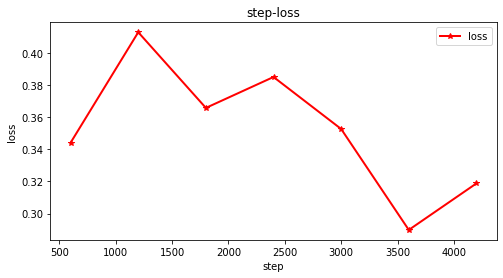

In [14]:
%pylab inline
fig=plt.figure(figsize=(8,4))
plt.plot(pub_data,v1,linestyle='-',label='loss',linewidth=2,color='red',marker='*',markersize=6)
plt.title('step-loss')
plt.xlabel('step')
plt.ylabel('loss')#为了防止X轴标签堆积，可以设置x轴刻度自动展现，并且45度倾斜#fig.autofmt_xdate(rotation = 45) 
plt.legend()
plt.show()


In [16]:
v1=[0.9126,0.9060]
v2=[ 0.8739,0.8522]
pub_data=[1,2]

C:\Users\Ccy\anaconda3\envs\py37_torch131\lib\site-packages\ipykernel_launcher.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  This is separate from the ipykernel package so we can avoid doing imports until


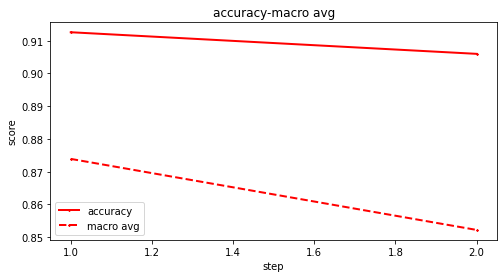

In [21]:
fig=plt.figure(figsize=(8,4))
plt.plot(pub_data,v1,linestyle='-',label='accuracy',linewidth=2,color='red',marker='*',markersize=2)
plt.plot(pub_data,v2,'b--',label='macro avg',linewidth=2,color='red',marker='*',markersize=2)
plt.title('accuracy-macro avg')
plt.xlabel('step')
plt.ylabel('score')#为了防止X轴标签堆积，可以设置x轴刻度自动展现，并且45度倾斜#fig.autofmt_xdate(rotation = 45) 
plt.legend()
plt.show()
